In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
source_image_array= []
target_image_array= []
source_image_landmarks= []
target_image_landmarks= []

def read_csv_file():


    DATASET_MEDIUM_DIR = 'dataset_medium.csv'
    Image.MAX_IMAGE_PIXELS = None
    
    
    imgs_dirs = []
    dataset_read_result = pd.read_csv(DATASET_MEDIUM_DIR)
    i = 0
    for each_img_dir, \
        each_landmarks_dir, \
        each_target_image, \
        each_target_landmarks, \
        each_status in zip(dataset_read_result['Source image'],
                           dataset_read_result['Source landmarks'],
                           dataset_read_result['Target image'],
                           dataset_read_result['Target landmarks'],
                           dataset_read_result['status']):
        if each_status=='training':
            each_img_dir = 'image/dataset_medium/' + each_img_dir
            each_landmarks_dir = 'landmark/' + each_landmarks_dir
            each_target_image = 'image/dataset_medium/' + each_target_image
            each_target_landmarks = 'landmark/' + each_target_landmarks 

            dataset_read_result.set_value(index=i, col='Source image', value=each_img_dir)
            dataset_read_result.set_value(index=i, col='Source landmarks', value=each_landmarks_dir)
            dataset_read_result.set_value(index=i, col='Target image', value=each_target_image)
            dataset_read_result.set_value(index=i, col='Target landmarks', value=each_target_landmarks)
            
            ######################################
            source_image_array.append(each_img_dir)
            target_image_array.append(each_target_image)
            source_image_landmarks.append(each_landmarks_dir)
            target_image_landmarks.append(each_target_landmarks)
            ##########################
            imgs_dirs.append(each_img_dir)
            i = i + 1

    print(dataset_read_result['Source image'][1])
    print(imgs_dirs[1])
    return dataset_read_result


dataset_read_result = read_csv_file()

# the first 10
# source_image_array = dataset_read_result['Source image']
# target_image_array = dataset_read_result['Target image']
# source_image_landmarks = dataset_read_result['Source landmarks']
# target_image_landmarks = dataset_read_result['Target landmarks']

D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


image/dataset_medium/COAD_01/scale-25pc/S6.jpg
image/dataset_medium/COAD_01/scale-25pc/S6.jpg


In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class matchNet(nn.Module):
    def __init__(self):
        #使用super()方法调用基类的构造器，即nn.Module.__init__(self)
        super(matchNet,self).__init__()
        
        
        ## note here wantna to combined two image together
        self.conv_0 = nn.Conv2d(3, 32, kernel_size=2)
        self.pool_0 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv_1 = nn.Conv2d(32, 64, kernel_size=2)
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv_2 = nn.Conv2d(64, 128, kernel_size=2, stride=1)
#         self.conv_3 = nn.Conv2d(128, 128, kernel_size=2, stride=1)
#         self.conv_4 = nn.Conv2d(128, 64, kernel_size=2, stride=1)
        self.pool_4 = torch.nn.MaxPool2d(kernel_size=2, stride=1)
        
        
        # input based on previous , output choose from 128, 256, 512
        self.bottleNeck = torch.nn.Linear(128, 512)
        
        # FC layers, input based on the previous, output choose from 128, 256, 512, 1024
        # this layer with the softmax
        self.fc_1 = torch.nn.Linear(1024, 256)
        self.fc_2 = torch.nn.Linear(256, 128)
        self.fc_3 = torch.nn.Linear(128, 1)
        self.sigmoid = torch.nn.Sigmoid()
        # self.dropout = nn.Dropout(p=0.2)
        
        
    def forward(self,x,y):
        
        
        ########################
        x = F.relu(self.conv_0(x))
        x = self.pool_0(x) 
        x = F.relu(self.conv_1(x))
        x = self.pool_1(x) 
        x = F.relu(self.conv_2(x))
#         x = F.relu(self.conv_3(x))
#         x = F.relu(self.conv_4(x))
        x = self.pool_4(x)
        
        x = x.view(-1, 128)
        x = F.relu(self.bottleNeck(x))
        ########################
        
        y = F.relu(self.conv_0(y))
        y = self.pool_0(y) 
        y = F.relu(self.conv_1(y))
        y = self.pool_1(y) 
        y = F.relu(self.conv_2(y))
#         y = F.relu(self.conv_3(y))
#         y = F.relu(self.conv_4(y))
        y = self.pool_4(y)
        
        y = y.view(-1, 128)
        y = F.relu(self.bottleNeck(y))
        #########################
        
        output =torch.cat((x, y),1)
        
        output =F.relu(self.fc_1(output))
            
        output = F.relu(self.fc_2(output))
        output = self.sigmoid(self.fc_3(output))
        
       
        return output

# First using the SIFT to get the point

In [4]:
import cv2
import numpy as np
print(cv2.__version__)

3.3.1


In [5]:
sift = cv2.xfeatures2d.SIFT_create()

imgname1 = source_image_array[1]
imgname2 = target_image_array[1]

In [6]:
scaling_ratio = 50

img1 = cv2.imread(imgname1)
height1, width1, channels = img1.shape
img2 = cv2.imread(imgname2)
height2, width2, channels = img2.shape

height1_resize = int(height1/scaling_ratio)
width1_resize = int(width1/scaling_ratio)

# print(height1) # 16308
# print(height1_resize) #326


height2_resize = int(height2/scaling_ratio)
width2_resize = int(width2/scaling_ratio)

# print(height2) # 13812
# print(height2_resize) #276

height_max = max(height1_resize, height2_resize)
width_max = max(width1_resize, width2_resize )

# print(height_max) # 326

height1_resize_add_pad = int((height_max - height1_resize)/2)
width1_resize_add_pad = int((width_max - width1_resize)/2)

height2_resize_add_pad = int((height_max - height2_resize)/2)
width2_resize_add_pad = int((width_max - width2_resize)/2)


img1 = cv2.resize(img1, (width1_resize,height1_resize))
img2 = cv2.resize(img2, (width2_resize,height2_resize))


color = [255, 255, 255]
image1 = cv2.copyMakeBorder(img1, height1_resize_add_pad, height1_resize_add_pad, width1_resize_add_pad, width1_resize_add_pad,cv2.BORDER_CONSTANT, value = color)
image2 = cv2.copyMakeBorder(img2, height2_resize_add_pad, height2_resize_add_pad, width2_resize_add_pad, width2_resize_add_pad,cv2.BORDER_CONSTANT, value = color)
image1 = cv2.resize(image1, (width_max,height_max))
image1 = cv2.resize(image1, (width_max,height_max))
height1, width1, channels = image1.shape
height2, width2, channels = image2.shape


# hmerge = np.hstack((image1, image2)) #水平拼接
# plt.imshow(hmerge,cmap='gray')#拼接显示为gray
# plt.show()

In [7]:
kp1, des1 = sift.detectAndCompute(image1,None)#des是描述子
kp2, des2 = sift.detectAndCompute(image2,None)
img3 = cv2.drawKeypoints(image1,kp1,image1,color=(255,0,255))
img4 = cv2.drawKeypoints(image2,kp2,image2,color=(255,0,255))

# hmerge = np.hstack((img3, img4)) #水平拼接
# plt.imshow(hmerge)#拼接显示为gray
# plt.show()

# 转化 keypoint to point

In [8]:
kp1[0].pt
kp1[0].pt[0] # x
kp1[0].pt[1] # y

52.571414947509766

around area can be changed 

In [9]:
def get_neighbourhood (x,y): 
    around_area = 8
    x_Upper_left = x-around_area
    y_Upper_left = y-around_area
    
    x_Lower_right = x+around_area
    y_Lower_right = y+around_area
    
    return x_Upper_left,y_Upper_left,x_Lower_right,y_Lower_right

In [10]:
x_Upper_left,y_Upper_left,x_Lower_right,y_Lower_right = get_neighbourhood (round(kp1[0].pt[0]),round(kp1[0].pt[1]))

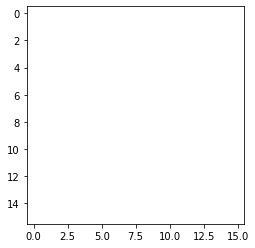

In [11]:
cropImg = image1[x_Upper_left:x_Lower_right, y_Upper_left:y_Lower_right]
plt.imshow(cropImg)#拼接显示为gray
plt.show()

In [12]:
source_landmark_read_result = pd.read_csv(source_image_landmarks[0])
target_landmark_read_result = pd.read_csv(target_image_landmarks[0])

In [13]:

img1 = cv2.imread(imgname1)
height1, width1, channels = img1.shape
img2 = cv2.imread(imgname2)
height2, width2, channels = img2.shape

source_cropImg_set = []
target_cropImg_set = []
for source_X, \
    source_Y ,\
    target_X,\
    target_Y in zip(source_landmark_read_result['X'],source_landmark_read_result['Y'],target_landmark_read_result['X'],target_landmark_read_result['Y']):
    
    source_x_Upper_left,source_y_Upper_left,source_x_Lower_right,source_y_Lower_right = get_neighbourhood (round(source_X),round(source_Y))
    target_x_Upper_left,target_y_Upper_left,target_x_Lower_right,target_y_Lower_right = get_neighbourhood (round(target_X),round(target_Y))
    
    source_cropImg = img1[source_y_Upper_left:source_y_Lower_right, source_x_Upper_left:source_x_Lower_right]
    target_cropImg = img2[target_y_Upper_left:target_y_Lower_right, target_x_Upper_left:target_x_Lower_right]
    
    # height, width, channels = source_cropImg.shape
    # print (source_x_Upper_left,source_x_Lower_right, source_y_Upper_left,source_y_Lower_right)
    print(source_cropImg.shape)
    source_cropImg_set.append(source_cropImg)
    target_cropImg_set.append(target_cropImg)
    ###### toDo use the two to make  CNN if they are the pairs


(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)


In [75]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
source_trainloader = torch.utils.data.DataLoader(source_cropImg_set, batch_size=1,
                                          shuffle=True, num_workers=1)
target_trainloader = torch.utils.data.DataLoader(target_cropImg_set, batch_size=1,
                                          shuffle=True, num_workers=1)

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [77]:
net = matchNet()
labels = 1
net.to(device)

matchNet(
  (conv_0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool_4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (bottleNeck): Linear(in_features=128, out_features=512, bias=True)
  (fc_1): Linear(in_features=1024, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=128, bias=True)
  (fc_3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [78]:
net = nn.DataParallel(net, list(range(1)))

In [79]:
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0
    for source,target in zip(source_trainloader, target_trainloader):
        # 置换 tensor from NWHC to NCWH
        b_size = 1
        label = torch.full((b_size,), labels,  device=device)
        net.zero_grad()
        
  
        
        optimizer.zero_grad()
        source=source.permute(0, 3, 1, 2)
        target=target.permute(0, 3, 1, 2)
        source = source.float()
        target = target.float()
        outputs = net(source,target)
        loss = criterion(outputs, label)
        
        
        loss.backward()
        
        #################################
        # Here wantna to train the 
        ##################################
        j = 0
        for target_false in target_trainloader:
            # if the same one 
            if j != i :
                
                # not same
                labels_false = 0
                label_false = torch.full((b_size,), labels_false,  device=device)
                target_false=target_false.permute(0, 3, 1, 2)
                target_false = target_false.float()
                outputs = net(source,target_false)
                loss_F = criterion(outputs, label_false)
#                 print(outputs)
#                 print(label_false)
#                 print(loss.item())
                optimizer.zero_grad()
                loss_F.backward()
                loss += loss_F
                
                optimizer.step()
                
            j = j+1
        optimizer.step()
        print(loss.item())
        
        i = i+1
        

1.7723798751831055
17.328847885131836
17.671894073486328
16.652467727661133
16.104459762573242
17.345600128173828


KeyboardInterrupt: 

# the main train

The train is for training each pairs

In [80]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print ('begin training.........')

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    print ('epoch , ',epoch)
    
    num = 0
    for source,target, s_landmark,t_landmark in zip(source_image_array[:180], target_image_array[:180], source_image_landmarks[:180] ,target_image_landmarks[:180]):
        imgname1 = source
        imgname2 = target
        source_landmark_read_result = pd.read_csv(s_landmark)
        target_landmark_read_result = pd.read_csv(t_landmark)
        
        labels = 1
        
        num = num + 1


        # read the image and put the small regin in the train loader
        img1 = cv2.imread(imgname1)
        height1, width1, channels = img1.shape
        img2 = cv2.imread(imgname2)
        height2, width2, channels = img2.shape

        source_cropImg_set = []
        target_cropImg_set = []
        for source_X, \
            source_Y ,\
            target_X,\
            target_Y in zip(source_landmark_read_result['X'],source_landmark_read_result['Y'],target_landmark_read_result['X'],target_landmark_read_result['Y']):

            source_x_Upper_left,source_y_Upper_left,source_x_Lower_right,source_y_Lower_right = get_neighbourhood (round(source_X),round(source_Y))
            target_x_Upper_left,target_y_Upper_left,target_x_Lower_right,target_y_Lower_right = get_neighbourhood (round(target_X),round(target_Y))

            source_cropImg = img1[source_y_Upper_left:source_y_Lower_right, source_x_Upper_left:source_x_Lower_right]
            target_cropImg = img2[target_y_Upper_left:target_y_Lower_right, target_x_Upper_left:target_x_Lower_right]

            # height, width, channels = source_cropImg.shape
            # print (source_x_Upper_left,source_x_Lower_right, source_y_Upper_left,source_y_Lower_right)
            #
            source_cropImg_set.append(source_cropImg)
            target_cropImg_set.append(target_cropImg)
            ###### toDo use the two to make  CNN if they are the pairs
        ############# put the patch into the train loader
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        source_trainloader = torch.utils.data.DataLoader(source_cropImg_set, batch_size=1,shuffle=True, num_workers=1)
        target_trainloader = torch.utils.data.DataLoader(target_cropImg_set, batch_size=1,shuffle=True, num_workers=1)


        ### tra

        i = 0
        for source,target in zip(source_trainloader, target_trainloader):
            # 置换 tensor from NWHC to NCWH
            b_size = 1
            label = torch.full((b_size,), labels,  device=device)
            net.zero_grad()



            optimizer.zero_grad()
            source=source.permute(0, 3, 1, 2)
            target=target.permute(0, 3, 1, 2)
            source = source.float()
            target = target.float()
            outputs = net(source,target)
            loss = criterion(outputs, label)


            loss.backward()

            #################################
            # Here wantna to train the 
            ##################################
            j = 0
            for target_false in target_trainloader:
                # if the same one 
                if j != i :

                    # not same
                    labels_false = 0
                    label_false = torch.full((b_size,), labels_false,  device=device)
                    target_false=target_false.permute(0, 3, 1, 2)
                    target_false = target_false.float()
                    outputs = net(source,target_false)
                    loss_F = criterion(outputs, label_false)
    #                 print(outputs)
    #                 print(label_false)
    #                 print(loss.item())
                    optimizer.zero_grad()
                    loss_F.backward()
                    loss += loss_F

                    optimizer.step()

                j = j+1
            optimizer.step()
            print(loss.item())

            i = i+1


begin training.........
epoch ,  0
16.748939514160156
15.687275886535645
17.226329803466797


KeyboardInterrupt: 

In [41]:
torch.save(net.state_dict(),'model/params.pkl')
torch.save(net,'model/model.pkl')

D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type matchNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
loss

tensor(14.6903, device='cuda:0', grad_fn=<AddBackward0>)

In [18]:
net.state_dict()

OrderedDict([('module.module.conv_0.weight', tensor([[[[-0.0054, -0.0755],
                        [ 0.1009, -0.2762]],
              
                       [[-0.2641, -0.0419],
                        [ 0.2619, -0.0495]],
              
                       [[ 0.0735,  0.1189],
                        [ 0.0972,  0.0812]]],
              
              
                      [[[ 0.1057,  0.0776],
                        [ 0.2608, -0.0108]],
              
                       [[ 0.1456,  0.1794],
                        [ 0.0585, -0.1877]],
              
                       [[ 0.0665,  0.1552],
                        [-0.2156,  0.2009]]],
              
              
                      [[[-0.0016, -0.1695],
                        [-0.1062, -0.0728]],
              
                       [[ 0.0826,  0.2793],
                        [-0.0301,  0.0950]],
              
                       [[-0.0894, -0.2496],
                        [-0.0378,  0.1349]]],
              


TypeError: 'int' object is not callable

In [114]:
num = 0
for source,target, s_landmark,t_landmark in zip(source_image_array[:300], target_image_array[:300],source_image_landmarks[:300] ,target_image_landmarks[:300]):
    print(s_landmark)
    num = num + 1

landmark/COAD_01/scale-25pc/S3.csv
landmark/COAD_01/scale-25pc/S6.csv
landmark/COAD_01/scale-25pc/S7.csv
landmark/COAD_01/scale-25pc/S6.csv
landmark/COAD_01/scale-25pc/S7.csv
landmark/COAD_01/scale-25pc/S7.csv
landmark/COAD_02/scale-25pc/S3.csv
landmark/COAD_02/scale-25pc/S6.csv
landmark/COAD_02/scale-25pc/S7.csv
landmark/COAD_02/scale-25pc/S6.csv
landmark/COAD_02/scale-25pc/S7.csv
landmark/COAD_02/scale-25pc/S7.csv
landmark/COAD_03/scale-25pc/S5.csv
landmark/COAD_04/scale-25pc/S5.csv
landmark/COAD_05/scale-25pc/S5-v1.csv
landmark/COAD_05/scale-25pc/S6.csv
landmark/COAD_05/scale-25pc/S7.csv
landmark/COAD_05/scale-25pc/S6.csv
landmark/COAD_05/scale-25pc/S7.csv
landmark/COAD_05/scale-25pc/S7.csv
landmark/COAD_06/scale-25pc/S5.csv
landmark/COAD_06/scale-25pc/S7.csv
landmark/COAD_06/scale-25pc/S7.csv
landmark/COAD_07/scale-25pc/S5.csv
landmark/COAD_07/scale-25pc/S7.csv
landmark/COAD_07/scale-25pc/S7.csv
landmark/COAD_08/scale-25pc/S3.csv
landmark/COAD_08/scale-25pc/S6.csv
landmark/COAD_08/

In [131]:
loss = 0.0
print('The loss is',loss)

The loss is 0.0


In [141]:
net = torch.load('model/model.pkl')
labels = 1
net.to(device)

DataParallel(
  (module): DataParallel(
    (module): matchNet(
      (conv_0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
      (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_1): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
      (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
      (pool_4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
      (bottleNeck): Linear(in_features=128, out_features=512, bias=True)
      (fc_1): Linear(in_features=1024, out_features=256, bias=True)
      (fc_2): Linear(in_features=256, out_features=128, bias=True)
      (fc_3): Linear(in_features=128, out_features=1, bias=True)
      (sigmoid): Sigmoid()
    )
  )
)

In [18]:
print (len(target_image_landmarks))

230


using sift

In [53]:
scaling_ratio = 50
imgname1 = source_image_array[181]
imgname2 = target_image_array[181]

img1 = cv2.imread(imgname1)
height1, width1, channels = img1.shape
img2 = cv2.imread(imgname2)
height2, width2, channels = img2.shape

height1_resize = int(height1/scaling_ratio)
width1_resize = int(width1/scaling_ratio)

# print(height1) # 16308
# print(height1_resize) #326


height2_resize = int(height2/scaling_ratio)
width2_resize = int(width2/scaling_ratio)

# print(height2) # 13812
# print(height2_resize) #276

height_max = max(height1_resize, height2_resize)
width_max = max(width1_resize, width2_resize )

# print(height_max) # 326

height1_resize_add_pad = int((height_max - height1_resize)/2)
width1_resize_add_pad = int((width_max - width1_resize)/2)

height2_resize_add_pad = int((height_max - height2_resize)/2)
width2_resize_add_pad = int((width_max - width2_resize)/2)


img1 = cv2.resize(img1, (width1_resize,height1_resize))
img2 = cv2.resize(img2, (width2_resize,height2_resize))


color = [255, 255, 255]
image1 = cv2.copyMakeBorder(img1, height1_resize_add_pad, height1_resize_add_pad, width1_resize_add_pad, width1_resize_add_pad,cv2.BORDER_CONSTANT, value = color)
image2 = cv2.copyMakeBorder(img2, height2_resize_add_pad, height2_resize_add_pad, width2_resize_add_pad, width2_resize_add_pad,cv2.BORDER_CONSTANT, value = color)
image1 = cv2.resize(image1, (width_max,height_max))
image1 = cv2.resize(image1, (width_max,height_max))
height1, width1, channels = image1.shape
height2, width2, channels = image2.shape

In [54]:
kp1_1, des1_1 = sift.detectAndCompute(image1,None)#des是描述子
kp2_2, des2_2 = sift.detectAndCompute(image2,None)
img3 = cv2.drawKeypoints(image1,kp1_1,image1,color=(255,0,255))
img4 = cv2.drawKeypoints(image2,kp2_2,image2,color=(255,0,255))

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1_1,des2_2, k=2)


source_cropImg_set = []
target_cropImg_set = []

# For each match...
for mat,n in matches:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    
    # x - columns
    # y - rows
    # Get the coordinates
    (x1,y1) = kp1_1[img1_idx].pt
    (x2,y2) = kp2_2[img2_idx].pt

    
    x_source = round(x1) # x
    y_source = round(y1) # y
    
    x_target = round(x2) # x
    y_target = round(y2) # y
    
    
    x_Upper_left_source,y_Upper_left_source,x_Lower_right_source,y_Lower_right_source = get_neighbourhood (x_source,y_source)
    x_Upper_left_target,y_Upper_left_target,x_Lower_right_target,y_Lower_right_target = get_neighbourhood (x_target,y_target)
    
    
    source_cropImg = image1[y_Upper_left_source:y_Lower_right_source, x_Upper_left_source:x_Lower_right_source]
    target_cropImg = image2[y_Upper_left_target:y_Lower_right_target, x_Upper_left_target:x_Lower_right_target]
    
    
    source_cropImg_set.append(source_cropImg)
    target_cropImg_set.append(target_cropImg)
    
#     plt.imshow(source_cropImg)#拼接显示为gray
#     plt.show()
#     break
#     # Append to each list
#     list_kp1.append((x1, y1))
#     list_kp2.append((x2, y2))
    
    
    

        
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# source_trainloader = torch.utils.data.DataLoader(source_cropImg_set, batch_size=1,shuffle=True, num_workers=1)
# target_trainloader = torch.utils.data.DataLoader(target_cropImg_set, batch_size=1,shuffle=True, num_workers=1)

# for i in range(len(target_cropImg_set)):
#     source = source_trainloader[i]
    
    

In [55]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
source_trainloader = torch.utils.data.DataLoader(source_cropImg_set, batch_size=1,shuffle=True, num_workers=1)
target_trainloader = torch.utils.data.DataLoader(target_cropImg_set, batch_size=1,shuffle=True, num_workers=1)


In [142]:
result = []
i = 0


for source,target in zip(source_trainloader, target_trainloader):
    source=source.permute(0, 3, 1, 2)
    target=target.permute(0, 3, 1, 2)
    source = source.float()
    target = target.float()
    outputs = net(source,target)
    
    result.append(outputs.item())
    print(outputs.item())

5.4215104627886035e-11
6.173234839979003e-11
1.2629215728754417e-10
4.936802702748544e-11
2.987894098804844e-10
1.3986253821762773e-10
9.082716523334255e-11
3.318163799281848e-11
1.1682810274749045e-10
1.0286179547014385e-10
4.818736729084172e-11
1.206373612117062e-10
5.68492475316873e-11
5.938089603363395e-11
4.6209737425417785e-11
1.1329979315854999e-10
4.4449985359129585e-11
5.5166957807495365e-11
1.2276921146359143e-10
6.743602204428711e-11
1.494918355771091e-10
7.608329244401801e-11
5.215327822383209e-11
1.300781010682428e-10
2.216342907812585e-11
8.487689023839451e-11
1.423050705051665e-10
1.197570237421175e-10
9.703677444905523e-11
7.310330812915211e-11
6.750731917914976e-11
6.413445469144463e-11
8.753560376550951e-11
6.605567481887675e-11
5.474860148568794e-11
1.1115330877942142e-10
6.194536550374607e-11
4.688517976636497e-11
9.802530315239366e-11
6.554712328465939e-11
3.740630027948555e-11
3.193579775628841e-11
1.7738921442855826e-10
1.1389996584787454e-10
7.000250379363138e-1

In [61]:
import heapq
# 最大的70个数的索引
max_num_index_list = map(result.index, heapq.nlargest(40, result))
index_list = list(max_num_index_list)

In [62]:
index_list.sort()
print(index_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [63]:
result

[2.0867581274064406e-10,
 2.377535945896625e-10,
 8.760228098481093e-10,
 8.315861332874874e-10,
 8.060592748826423e-10,
 6.203986768760217e-10,
 4.0044265126049083e-10,
 3.564940842526454e-10,
 6.165459809359675e-10,
 2.9739022355812494e-10,
 2.343937266502394e-10,
 4.787727436728062e-10,
 5.183595219726556e-10,
 1.2200290777641953e-09,
 2.1110538317437033e-10,
 3.8519520906277194e-10,
 4.603225800536848e-09,
 7.587436234857137e-10,
 7.983722016824402e-10,
 8.653975314132367e-10,
 3.97482519121084e-10,
 3.7811465070092254e-10,
 2.6917026940687094e-10,
 5.765318222827887e-10,
 5.935115177102546e-10,
 3.575168217029301e-10,
 9.142407386697471e-10,
 5.945436365450973e-10,
 4.2600803440429047e-10,
 6.852742817642365e-10,
 4.01588401421904e-10,
 5.612644238262021e-10,
 7.486520292587784e-10]

In [64]:
len(target_cropImg_set)

33

In [65]:
source_point = []
target_point = []
for index in index_list:
    m,n = matches[index]
    img1_idx = m.queryIdx
    img2_idx = m.trainIdx

    
    # x - columns
    # y - rows
    # Get the coordinates
    (x1,y1) = kp1_1[img1_idx].pt
    (x2,y2) = kp2_2[img2_idx].pt
    source_point.append((x1,y1))
    target_point.append((x2,y2))
    

In [66]:
len(matches)

33

In [67]:
source_point

[(9.29007625579834, 13.574542999267578),
 (11.516609191894531, 18.710391998291016),
 (12.957582473754883, 14.038883209228516),
 (18.042936325073242, 24.707015991210938),
 (22.526073455810547, 19.9005184173584),
 (27.435264587402344, 32.18349075317383),
 (27.435264587402344, 32.18349075317383),
 (27.435264587402344, 32.18349075317383),
 (29.771909713745117, 14.341424942016602),
 (33.070526123046875, 28.06848907470703),
 (36.6353874206543, 26.41019630432129),
 (36.652488708496094, 16.151445388793945),
 (36.652488708496094, 16.151445388793945),
 (46.25938415527344, 21.489517211914062),
 (46.25938415527344, 21.489517211914062),
 (56.64473342895508, 21.111722946166992),
 (56.64473342895508, 21.111722946166992),
 (65.81265258789062, 15.687283515930176),
 (68.36320495605469, 30.403179168701172),
 (72.5555191040039, 27.344587326049805),
 (75.89175415039062, 23.70098876953125),
 (83.86629486083984, 25.39244842529297),
 (84.68606567382812, 13.358914375305176),
 (84.8282699584961, 19.564733505249

In [34]:
source_point[0][0]

65.36299896240234

In [68]:
source_X = []
source_Y = []
for source_X_,sourceY_ in source_point:
    source_X.append(round(source_X_))
    source_Y.append(round(sourceY_))

target_X = []
target_Y = []

for source_X_,sourceY_ in target_point:
    target_X.append(round(source_X_))
    target_Y.append(round(sourceY_))


In [36]:
range70 = range(40)
def to_csv(x_1,x_2,y_1,y_2,i):
    x_1_tocsv = x_1.detach().numpy()
    x_1_tocsv = x_1_tocsv[0]
    #print(x_1_tocsv)

    x_2_tocsv = x_2.detach().numpy()
    x_2_tocsv = x_2_tocsv[0]
    #print(x_2_tocsv)

    y_2_tocsv = y_2.detach().numpy()
    y_2_tocsv = y_2_tocsv[0]
    #print(y_2_tocsv)

    y_1_tocsv = y_1.detach().numpy()
    y_1_tocsv = y_1_tocsv[0]
    
    df = pandas.DataFrame(data={"": range70,"X": x_1_tocsv.astype(int), "Y": x_2_tocsv.astype(int)})
    source_dir = "real_result/source_landmark"+ str(i) +".csv"
    df.to_csv(source_dir, sep=',',index=False)
    
    df = pandas.DataFrame(data={"": range70,"X": y_1_tocsv.astype(int), "Y": y_2_tocsv.astype(int)})
    source_dir = "real_result/target_landmark"+ str(i) +".csv"
    df.to_csv(source_dir, sep=',',index=False)

In [37]:
to_csv(source_point[:][0],source_point[:][1],target_point[:][0],target_point[:][1],i)

AttributeError: 'tuple' object has no attribute 'detach'

In [69]:
source_dataframe = pd.DataFrame({'X':source_X,'Y':source_Y})

In [71]:
source_dataframe.to_csv("test181.csv",index=False,sep=',')

In [88]:
source_image_landmark = 'test181.csv'
current = pd.read_csv(source_image_landmark)
X = current['X']
Y = current['Y']
coords_1 = []
for x,y in zip(X,Y):
    coords_1.append((x,y))
print(coords_1)

source_image_landmark = source_image_landmarks[181]
current = pd.read_csv(source_image_landmark)
X = current['X']
Y = current['Y']
coords_2 = []
for x,y in zip(X,Y):
    coords_2.append((x/50,y/50))
print(coords_2)

[(9, 14), (12, 19), (13, 14), (18, 25), (23, 20), (27, 32), (27, 32), (27, 32), (30, 14), (33, 28), (37, 26), (37, 16), (37, 16), (46, 21), (46, 21), (57, 21), (57, 21), (66, 16), (68, 30), (73, 27), (76, 24), (84, 25), (85, 13), (85, 20), (89, 28), (92, 15), (93, 17), (101, 18), (154, 9), (161, 18), (161, 18), (164, 14), (164, 14)]
[(27.551665, 13.183335), (22.6, 13.435), (26.018335, 10.541665), (25.318335, 15.541665), (25.041665, 18.066665), (16.825, 21.746664999999997), (22.103335, 20.026665), (21.173335, 18.393335), (21.976664999999997, 22.61), (28.313335000000002, 22.238335000000003), (29.766665, 18.596665), (34.256665, 16.691665), (33.313335, 11.821665000000001), (36.958335000000005, 21.081664999999997), (23.136664999999997, 26.845), (16.793335, 29.291665), (22.573335, 35.285), (27.5, 32.268335), (26.673335, 28.093335000000003), (33.965, 25.471664999999998), (38.033335, 31.838335), (34.696664999999996, 37.281665), (46.905, 33.388335000000005), (44.606665, 28.803335), (45.82, 19.4

In [89]:
from scipy.spatial import distance


TRE = distance.cdist(coords_1, coords_2, "euclidean") 
print(TRE)

[[ 18.56963155  13.61173115  17.36616846 ... 150.42765603 157.9866134
  163.40017625]
 [ 16.60385124  11.97201842  16.37245086 ... 147.61650673 154.8274739
  160.47061289]
 [ 14.57456332   9.61661193  13.46985995 ... 146.42850261 153.99128772
  159.40018068]
 ...
 [133.53523271 138.47526575 135.18756099 ...   7.23327158   6.79979213
   12.00406598]
 [136.45077891 141.4011288  138.02499758 ...   5.52390693   8.04387114
    8.40342787]
 [136.45077891 141.4011288  138.02499758 ...   5.52390693   8.04387114
    8.40342787]]


In [90]:
import numpy
source  = Image.open(source_image_array[181])
width, height = source.size

sqrt_height_square_and_weight = numpy.sqrt(numpy.square(width)+numpy.square(height))
rTRE = TRE/sqrt_height_square_and_weight
print(rTRE)

[[0.00200024 0.0014662  0.00187061 ... 0.01620341 0.01701763 0.01760076]
 [0.00178849 0.00128957 0.00176357 ... 0.01590061 0.01667734 0.0172852 ]
 [0.00156991 0.00103586 0.00145091 ... 0.01577264 0.01658727 0.01716989]
 ...
 [0.01438383 0.01491595 0.01456182 ... 0.00077914 0.00073244 0.00129303]
 [0.01469788 0.01523111 0.01486745 ... 0.00059501 0.00086645 0.00090518]
 [0.01469788 0.01523111 0.01486745 ... 0.00059501 0.00086645 0.00090518]]


In [91]:
rTRE_mean = numpy.mean(rTRE)
print(rTRE_mean)

0.005445542390265504


##### real auto

In [166]:
import heapq
import time

code_run_time_set = []
for index_forsort in range(len(target_image_landmarks)):
    
    # time 
    t0_0 = time.time()
    scaling_ratio = 50
    imgname1 = source_image_array[index_forsort]
    imgname2 = target_image_array[index_forsort]

    img1 = cv2.imread(imgname1)
    height1, width1, channels = img1.shape
    img2 = cv2.imread(imgname2)
    height2, width2, channels = img2.shape

    height1_resize = int(height1/scaling_ratio)
    width1_resize = int(width1/scaling_ratio)

    # print(height1) # 16308
    # print(height1_resize) #326


    height2_resize = int(height2/scaling_ratio)
    width2_resize = int(width2/scaling_ratio)

    # print(height2) # 13812
    # print(height2_resize) #276

    height_max = max(height1_resize, height2_resize)
    width_max = max(width1_resize, width2_resize )

    # print(height_max) # 326

    height1_resize_add_pad = int((height_max - height1_resize)/2)
    width1_resize_add_pad = int((width_max - width1_resize)/2)

    height2_resize_add_pad = int((height_max - height2_resize)/2)
    width2_resize_add_pad = int((width_max - width2_resize)/2)


    img1 = cv2.resize(img1, (width1_resize,height1_resize))
    img2 = cv2.resize(img2, (width2_resize,height2_resize))


    color = [255, 255, 255]
    image1 = cv2.copyMakeBorder(img1, height1_resize_add_pad, height1_resize_add_pad, width1_resize_add_pad, width1_resize_add_pad,cv2.BORDER_CONSTANT, value = color)
    image2 = cv2.copyMakeBorder(img2, height2_resize_add_pad, height2_resize_add_pad, width2_resize_add_pad, width2_resize_add_pad,cv2.BORDER_CONSTANT, value = color)
    image1 = cv2.resize(image1, (width_max,height_max))
    image1 = cv2.resize(image1, (width_max,height_max))
    height1, width1, channels = image1.shape
    height2, width2, channels = image2.shape

    kp1_1, des1_1 = sift.detectAndCompute(image1,None)#des是描述子
    kp2_2, des2_2 = sift.detectAndCompute(image2,None)
    img3 = cv2.drawKeypoints(image1,kp1_1,image1,color=(255,0,255))
    img4 = cv2.drawKeypoints(image2,kp2_2,image2,color=(255,0,255))

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1_1,des2_2, k=2)


    source_cropImg_set = []
    target_cropImg_set = []

    # For each match...
    for mat,n in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx


        # x - columns
        # y - rows
        # Get the coordinates
        (x1,y1) = kp1_1[img1_idx].pt
        (x2,y2) = kp2_2[img2_idx].pt


        x_source = round(x1) # x
        y_source = round(y1) # y

        x_target = round(x2) # x
        y_target = round(y2) # y


        x_Upper_left_source,y_Upper_left_source,x_Lower_right_source,y_Lower_right_source = get_neighbourhood (x_source,y_source)
        x_Upper_left_target,y_Upper_left_target,x_Lower_right_target,y_Lower_right_target = get_neighbourhood (x_target,y_target)


        
        source_cropImg = image1[y_Upper_left_source:y_Lower_right_source, x_Upper_left_source:x_Lower_right_source]
        target_cropImg = image2[y_Upper_left_target:y_Lower_right_target, x_Upper_left_target:x_Lower_right_target]

        height_source, width_source, channels = source_cropImg.shape
        height_target, width_target, channels = target_cropImg.shape
    
        if ((abs( (height_source)) != 16 )or (abs( (width_source)) != 16 )) and (((abs( (height_source)) != 0 )and (abs( (width_source)) != 0 ))and((abs( (height_target)) != 0 )and (abs( (width_target) )!= 0 ))):
#             print("aaaa")
            source_cropImg=cv2.resize(source_cropImg,(16,16),interpolation=cv2.INTER_CUBIC)
        if ((abs( (height_target)) != 16 )or (abs( (width_target) )!= 16 )) and (((abs( (height_source)) != 0 )and (abs( (width_source)) != 0 ))and((abs( (height_target)) != 0 )and (abs( (width_target) )!= 0 ))):
#             print("bbbb")
            target_cropImg=cv2.resize(target_cropImg,(16,16),interpolation=cv2.INTER_CUBIC)

        if (((abs( (height_source)) != 0 )and (abs( (width_source)) != 0 ))and((abs( (height_target)) != 0 )and (abs( (width_target) )!= 0 ))):
            source_cropImg_set.append(source_cropImg)
            target_cropImg_set.append(target_cropImg)
            

    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    source_trainloader = torch.utils.data.DataLoader(source_cropImg_set, batch_size=1,shuffle=True, num_workers=1)
    target_trainloader = torch.utils.data.DataLoader(target_cropImg_set, batch_size=1,shuffle=True, num_workers=1)

    result = []
    i = 0


    
    for source,target in zip(source_trainloader, target_trainloader):
        source=source.permute(0, 3, 1, 2)
        target=target.permute(0, 3, 1, 2)
        
#         print(source.shape)
#         print(target.shape)
        
        source = source.float()
        target = target.float()
        outputs = net(source,target)

        result.append(outputs.item())
        # print(outputs.item())

    # 最大的70个数的索引
    max_num_index_list = map(result.index, heapq.nlargest(70, result))
    index_list = list(max_num_index_list)
    
    code_running_time = time.time() - t0_0
    # runing in minutes
    code_run_time_set.append(code_running_time/60)
    
    source_point = []
    target_point = []
    for index in index_list:
        m,n = matches[index]
        img1_idx = m.queryIdx
        img2_idx = m.trainIdx


        # x - columns
        # y - rows
        # Get the coordinates
        (x1,y1) = kp1_1[img1_idx].pt
        (x2,y2) = kp2_2[img2_idx].pt
        source_point.append((x1,y1))
        target_point.append((x2,y2))

    source_X = []
    source_Y = []
    for source_X_,sourceY_ in source_point:
        source_X.append(round(source_X_))
        source_Y.append(round(sourceY_))

    target_X = []
    target_Y = []

    # print(source_point)



    for source_X_,sourceY_ in target_point:
        target_X.append(round(source_X_))
        target_Y.append(round(sourceY_))


    source_dataframe = pd.DataFrame({'X':source_X,'Y':source_Y})
    
    target_dataframe = pd.DataFrame({'X':target_X,'Y':target_Y})
    
    
    print(str(index_forsort))

    file_name = './results/source/'+ str(index_forsort)+'.csv'
    file_name_t = './results/target/'+ str(index_forsort)+'.csv'
    
    
    source_dataframe.to_csv(file_name,index=False,sep=',')
    target_dataframe.to_csv(file_name_t,index=False,sep=',')
    
run_time_frame = pd.DataFrame({'run_time':code_run_time_set})

code_file = 'code_run_time.csv'


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


error: C:\Anaconda2\conda-bld\opencv-contrib_1513946725639\work\opencv\modules\features2d\src\matchers.cpp:744: error: (-215) _queryDescriptors.type() == trainDescType in function cv::BFMatcher::knnMatchImpl


In [167]:
run_time_frame = pd.DataFrame({'run_time':code_run_time_set})

code_file = 'code_run_time.csv'
run_time_frame.to_csv(code_file,index=False,sep=',')

In [158]:
import time

for ssss in range(2):
    t0 = time.time()
    time.sleep(1)
    print ((time.time() - t0)/60)

0.01667393445968628
0.016679314772288005


In [168]:
len(dataset_read_result)

481

In [20]:
from scipy.spatial import distance
import numpy


rTRE_Set_mean = []
for index_forsort in range(215):
    file_name = './results/source/'+ str(index_forsort)+'.csv'
    file_name_t = './results/target/'+ str(index_forsort)+'.csv'
    
    source_image_landmark = file_name
    current = pd.read_csv(source_image_landmark)
    X = current['X']
    Y = current['Y']
    coords_1 = []
    for x,y in zip(X,Y):
        coords_1.append((x,y))
    

    source_image_landmark = source_image_landmarks[index_forsort]
    current = pd.read_csv(source_image_landmark)
    X = current['X']
    Y = current['Y']
    coords_2 = []
    for x,y in zip(X,Y):
        coords_2.append((x/50,y/50))
    # print(coords_2)
    



    TRE = distance.cdist(coords_1, coords_2, "euclidean") 
    # print(TRE)
    
    source  = Image.open(source_image_array[index_forsort])s
    width, height = source.size

    sqrt_height_square_and_weight = numpy.sqrt(numpy.square(width)+numpy.square(height))
    rTRE = TRE/sqrt_height_square_and_weight
    
    
    rTRE_mean = numpy.mean(rTRE)
    rTRE_Set_mean.append(rTRE_mean)
    print(rTRE_mean)

0.006199793965656844
0.005639855794552274
0.005986731269860933
0.005627432413802426
0.005965269187743045
0.0061276605520605215
0.005701456019724782
0.005200781967760847
0.005528222366914637
0.0052583283992167495
0.005501553729219534
0.005476025247660777
0.005227774430035654
0.006121641235927923
0.004950821158065245
0.005081085550285571
0.004741658492041153
0.005008461325867611
0.004783281357425561
0.004691880623521339
0.00498398165937995
0.004864890725957356
0.004793607089081299
0.005599479628204416
0.0055910243883209535
0.005472379682776843
0.005425937530179276
0.005784072055602043
0.005752315482678392
0.005502382149811336
0.00604404317766431
0.0058919269670177675
0.004906091579817605
0.004838460835834418
0.004902611180998072
0.0051842927513638705
0.004894921041524879
0.004882031525640329
0.005702051838236687
0.005227998502448002
0.005002946516773985
0.004930157240385527
0.0048935938063110395
0.004654453669385491
0.0055277706112815735
0.005456915581468482
0.005418981096204422
0.005691

In [4]:
len(target_image_landmarks)

230

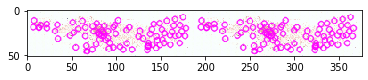

In [33]:
for index_forsort in range(215):

    file_name = './results/source/'+ str(index_forsort)+'.csv'
    file_name_t = './results/target/'+ str(index_forsort)+'.csv'

    source_image_landmark = file_name
    current = pd.read_csv(source_image_landmark)
    X = current['X']
    Y = current['Y']
    coords_1 = []
    for x,y in zip(X,Y):
        coords_1.append((x,y))

    source_image_landmark = source_image_landmarks[index_forsort]
    current = pd.read_csv(source_image_landmark)
    X = current['X']
    Y = current['Y']
    coords_2 = []
    for x,y in zip(X,Y):
        coords_2.append((x/50,y/50))

    scaling_ratio = 50
    imgname1 = source_image_array[index_forsort]
    imgname2 = target_image_array[index_forsort]

    img1 = cv2.imread(imgname1)
    height1, width1, channels = img1.shape
    img2 = cv2.imread(imgname2)
    height2, width2, channels = img2.shape

    height1_resize = int(height1/scaling_ratio)
    width1_resize = int(width1/scaling_ratio)

    # print(height1) # 16308
    # print(height1_resize) #326


    height2_resize = int(height2/scaling_ratio)
    width2_resize = int(width2/scaling_ratio)

    # print(height2) # 13812
    # print(height2_resize) #276

    height_max = max(height1_resize, height2_resize)
    width_max = max(width1_resize, width2_resize )

    # print(height_max) # 326

    height1_resize_add_pad = int((height_max - height1_resize)/2)
    width1_resize_add_pad = int((width_max - width1_resize)/2)

    height2_resize_add_pad = int((height_max - height2_resize)/2)
    width2_resize_add_pad = int((width_max - width2_resize)/2)


    img1 = cv2.resize(img1, (width1_resize,height1_resize))
    img2 = cv2.resize(img2, (width2_resize,height2_resize))


    pts = cv2.KeyPoint_convert(coords_1)
    pts_truth = cv2.KeyPoint_convert(coords_2)
    img3 = cv2.drawKeypoints(img1,pts,img1,color=(255,0,255)) #画出特征点，并显示为红色圆圈
    img4 = cv2.drawKeypoints(img1,pts_truth,img1,color=(255,0,255)) #画出特征点，并显示为红色圆圈
    import numpy as np
    hmerge = np.hstack((img3, img4)) #水平拼接
    # img4 = cv2.drawKeypoints(img2,kp2,img2,color=(255,0,255)) #画出特征点，并显示为红色圆圈



    plt.imshow(hmerge,cmap='gray')#拼接显示为gray
    file_name_image = './results/image/'+ str(index_forsort)+'.png'
    plt.savefig(file_name_image)
#     plt.show()

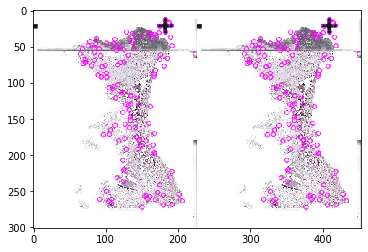

In [32]:

plt.imshow(hmerge,cmap='gray')#拼接显示为gray
file_name_image = './results/image/'+ str(1)+'.png'
plt.savefig(file_name_image)
plt.show()

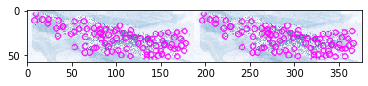

In [8]:
for index_forsort in range(215):

    file_name = './results/source/'+ str(index_forsort)+'.csv'
    file_name_t = './results/target/'+ str(index_forsort)+'.csv'

    source_image_landmark = file_name_t
    current = pd.read_csv(source_image_landmark)
    X = current['X']
    Y = current['Y']
    coords_1 = []
    for x,y in zip(X,Y):
        coords_1.append((x,y))

    source_image_landmark = target_image_landmarks[index_forsort]
    current = pd.read_csv(source_image_landmark)
    X = current['X']
    Y = current['Y']
    coords_2 = []
    for x,y in zip(X,Y):
        coords_2.append((x/50,y/50))

    scaling_ratio = 50
    imgname1 = source_image_array[index_forsort]
    imgname2 = target_image_array[index_forsort]

    img1 = cv2.imread(imgname1)
    height1, width1, channels = img1.shape
    img2 = cv2.imread(imgname2)
    height2, width2, channels = img2.shape

    height1_resize = int(height1/scaling_ratio)
    width1_resize = int(width1/scaling_ratio)

    # print(height1) # 16308
    # print(height1_resize) #326


    height2_resize = int(height2/scaling_ratio)
    width2_resize = int(width2/scaling_ratio)

    # print(height2) # 13812
    # print(height2_resize) #276

    height_max = max(height1_resize, height2_resize)
    width_max = max(width1_resize, width2_resize )

    # print(height_max) # 326

    height1_resize_add_pad = int((height_max - height1_resize)/2)
    width1_resize_add_pad = int((width_max - width1_resize)/2)

    height2_resize_add_pad = int((height_max - height2_resize)/2)
    width2_resize_add_pad = int((width_max - width2_resize)/2)


    img1 = cv2.resize(img1, (width1_resize,height1_resize))
    img2 = cv2.resize(img2, (width2_resize,height2_resize))


    pts = cv2.KeyPoint_convert(coords_1)
    pts_truth = cv2.KeyPoint_convert(coords_2)
    img3 = cv2.drawKeypoints(img2,pts,img2,color=(255,0,255)) #画出特征点，并显示为红色圆圈
    img4 = cv2.drawKeypoints(img2,pts_truth,img2,color=(255,0,255)) #画出特征点，并显示为红色圆圈
    import numpy as np
    hmerge = np.hstack((img3, img4)) #水平拼接
    # img4 = cv2.drawKeypoints(img2,kp2,img2,color=(255,0,255)) #画出特征点，并显示为红色圆圈



    plt.imshow(hmerge,cmap='gray')#拼接显示为gray
    file_name_image = './results/image_target/'+ str(index_forsort)+'.png'
    plt.savefig(file_name_image)